In [4]:

import pandas as pd
from unidecode import unidecode
from datetime import datetime
import numpy as np
import seaborn as sn
#Gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


#spacy
import spacy
from spacy.lang.pt.examples import sentences 
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

In [5]:
gensim.__version__

'4.1.2'

### Importando os dados

In [6]:
df = pd.read_excel('atas_bacen.xlsx')
df.columns = ['Reuniao','Document']

### Retirando os as sessões sem análise qualitativa

In [7]:

for num,e in enumerate(df['Document']):
    sumario_position = e.find('SUMÁRIO DOS DADOS ANALISADOS PELO COPOM')
    if sumario_position != -1:
        df.loc[num,'Document'] = df.loc[num,'Document'][:sumario_position]
    

### Dropando as missings

In [8]:
df = df.dropna(subset=['Reuniao'])
df = df.reset_index(drop=True)

### Tokenizando as atas em frases

In [9]:


def agrupa_frases(split):
    # Correção de frases quebradas no split '. '. 
    # Agrupa as frases quebradas com eles iniciam com letra minuscula
    i = 0
    exclude = []
    while i+1 < len(split):
        sumed_l = []
        # Retirando os espaços vazios nas extremidades
        split[i] = split[i].strip()
        last_value = split[i]
        last_idx = i
        
        while ((split[i + 1][0]).isupper() == False):
            
            # Concatenando frases cuja letra inicial é minúscula
            last_value += ' ' + split[i + 1]
            exclude.append(split[i + 1])
            i+=1
            
            if i + 1 == len(split):
                break


        split[last_idx] = last_value
        i+=1
    
    # Removendo as concatenadas
    for d in exclude:
        split.remove(d)
    
    return split


In [10]:
df_f = pd.DataFrame(columns=['ata','sentenca'])


for num,ata in enumerate(df['Document']):
    # Separando cada documento como uma única sentência
    frases = ata.split('. ')
    if '' in frases:
        frases.remove('')
    #Agrupando 
    frases = agrupa_frases(frases)
    
    # Atrelando as frases separas e tratadas em um novo dataframe
    for f in frases:
        df_f.loc[len(df_f) + 1,'sentenca'] = f
        df_f.loc[len(df_f),'ata'] = df.loc[num,'Reuniao']
    
    

### Extrair data das atas

In [11]:
df_f.ata = df_f.ata.apply(lambda x:x.replace(',',''))
df_f.ata

1        247ª Reunião - 14-15 junho 2022
2        247ª Reunião - 14-15 junho 2022
3        247ª Reunião - 14-15 junho 2022
4        247ª Reunião - 14-15 junho 2022
5        247ª Reunião - 14-15 junho 2022
                      ...               
23004         21ª Reunião - janeiro 1998
23005         21ª Reunião - janeiro 1998
23006         21ª Reunião - janeiro 1998
23007         21ª Reunião - janeiro 1998
23008         21ª Reunião - janeiro 1998
Name: ata, Length: 23008, dtype: object

In [12]:
ata_tokenized = df_f.ata.apply(lambda x:x.split(' '))
df_f['ano'] = ata_tokenized.apply(lambda x:x[-1])
df_f['mes'] = ata_tokenized.apply(lambda x:x[-2])

In [13]:
df_f['mes'].unique()

array(['junho', 'maio', 'março', 'fevereiro', 'dezembro', 'outubro',
       'setembro', 'agosto', 'janeiro', 'julho', 'abril', 'novembro'],
      dtype=object)

In [14]:
meses_dict = {
    'janeiro':'01',
    'fevereiro':'02',
    'março':'03',
    'abril':'04',
    'maio':'05',
    'junho':'06',
    'julho':'07',
    'agosto':'08',
    'setembro':'09',
    'outubro':'10',
    'novembro':'11',
    'dezembro':'12'
}

In [15]:
for num,(ano,mes) in enumerate(zip(df_f['ano'],df_f['mes'])):
    data =f'{meses_dict[mes]}/{ano}'
    df_f.loc[num+1,'data'] = datetime.strptime(data, '%m/%Y')

### Tokenizar as palavras

In [16]:
df_f['tokenized'] = df_f['sentenca'].apply(lambda x:x.split(' '))


In [74]:
df_f['Contagem de Palavras'] = df_f['tokenized'].apply(lambda x:len(x))

df_counter = df_f.groupby('ata').agg({
    'count_words':'sum',
    'data':'max'
})

### Análise Exploratória das ATAS

https://www.bcb.gov.br/publicacoes/atascopom/cronologicos

In [18]:
df_f.data.max()

Timestamp('2022-06-01 00:00:00')

In [19]:
df_f.data

1       2022-06-01
2       2022-06-01
3       2022-06-01
4       2022-06-01
5       2022-06-01
           ...    
23004   1998-01-01
23005   1998-01-01
23006   1998-01-01
23007   1998-01-01
23008   1998-01-01
Name: data, Length: 23008, dtype: datetime64[ns]

In [20]:
df_f.data.min()

Timestamp('1998-01-01 00:00:00')

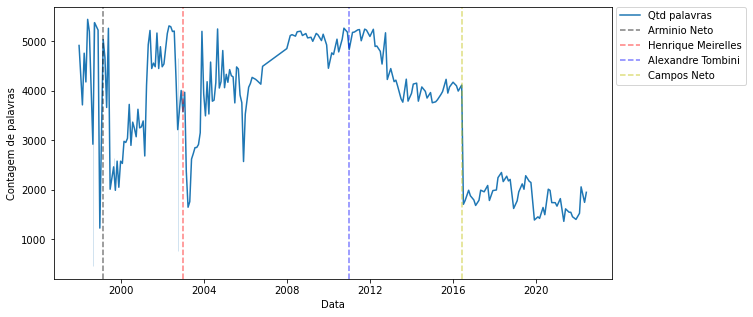

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.lineplot(data=df_counter, x="data", y="count_words",label= 'Qtd palavras')

#plt.title('Contagem de palavras das atas do COPOM')
plt.axvline(x=date(1999, 3, 4),color='k',label='Arminio Neto', alpha= 0.5,ls='--')
plt.axvline(x=date(2003, 1, 1),color='r',label='Henrique Meirelles', alpha= 0.5,ls='--')
plt.axvline(x=date(2011, 1, 1),color='b',label='Alexandre Tombini', alpha= 0.5,ls='--')
plt.axvline(x=date(2016, 6, 8),color='y',label='Campos Neto', alpha= 0.5,ls='--')
# This will add label to X-axis
plt.xlabel( "Data")
# This will add label to Y-axis
plt.ylabel( "Contagem de palavras")
plt.legend(loc="upper right",bbox_to_anchor=(1.25, 1.02))


De 2000 à 2016, houve ciclos no tamanho das atas em uma direção ascendente. Foi em 2016, no perido Tombini que houve uma quebra estrutural de como as atas são formuladas. Isso pode gerar impacto na modelagem, principalmente no que tange à análise de sentimento.

### Arminio Neto

In [24]:
neto = df_f[(df_f.data > '1999-3-4') & (df_f.data < '2003-1-1')].groupby('ata')['count_words'].sum().describe()
neto

count      45.000000
mean     3756.177778
std      1131.975291
min       762.000000
25%      2955.000000
50%      3723.000000
75%      4653.000000
max      5307.000000
Name: count_words, dtype: float64

### Henrique Meirelles

In [25]:
meirelles = df_f[(df_f.data > '1999-3-4') & (df_f.data < '2003-1-1')].groupby('ata')['count_words'].sum().describe()
meirelles

count      45.000000
mean     3756.177778
std      1131.975291
min       762.000000
25%      2955.000000
50%      3723.000000
75%      4653.000000
max      5307.000000
Name: count_words, dtype: float64

### Alexandre Tombini

In [26]:
tombini = df_f[(df_f.data > '2011-1-1') & (df_f.data < '2016-6-8')].groupby('ata')['count_words'].sum().describe()
tombini

count      43.000000
mean     4359.837209
std       530.233189
min      3756.000000
25%      3956.500000
50%      4152.000000
75%      4896.500000
max      5242.000000
Name: count_words, dtype: float64

### Campos Neto

In [27]:
campos= df_f[(df_f.data > '2016-6-8')].groupby('ata')['count_words'].sum().describe()
campos

count      48.000000
mean     1844.395833
std       272.893771
min      1363.000000
25%      1638.000000
50%      1808.000000
75%      2023.750000
max      2349.000000
Name: count_words, dtype: float64

In [28]:
consolidado_counts = pd.concat([neto,meirelles,tombini,campos],axis=1)
consolidado_counts.columns = ['neto','meirelles','tombini','campos']

In [29]:
consolidado_counts = consolidado_counts.apply(lambda x:round(x,2))

In [30]:
consolidado_counts.to_csv('Contagem Presidentes.csv',sep=';')

## Pré-processamento dos dados

### Lemmatização das sentenças

A lemmatização será usada para a modelagem de topicos por LDA, por isso é interessante usar somente as palavras com conteúdo semântico forte, por isso será usado somente as palavras das seguintes classes:

- Verbo
- Substantivo
- Adjetivo
- Advérbio

In [31]:
#,'ADP','PROPN','INTJ','CCONJ','PART','SCONJ','DET'
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("pt_core_news_sm")
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [32]:
lemmatized_texts = lemmatization(df_f.sentenca)
df_f['lemmatized_text'] = lemmatized_texts

In [33]:

stopwords = stopwords.words('portuguese')

Retirando as stopwords e excluindo as palavras relacionadas a datas que ocorrem com bastante frequência nas atas

In [34]:
months = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
palavras_data = ['mês','ano','dia','semana','trimestre','bimestre','semestre','década']

In [35]:
stopwords.extend(months)
stopwords.extend(palavras_data)

In [36]:
stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

### Stemming

Farei o steeming para usar na análise de sentimento. Por se mostrar mais ajustado ao dicionário lexico do economês.

In [37]:
from nltk.stem import RSLPStemmer
stemmer = RSLPStemmer()
def stemming(frase):
    frase = frase.strip().split(' ')
    
    nova_frase = []
    for w in frase:
        if w != '':
            nova_frase.append(stemmer.stem(w))
    
    return ' '.join(nova_frase)
    
    

In [38]:
df_f['stemmed_text'] = df_f.sentenca.apply(lambda x :stemming(x))

In [39]:
def retirar_pontuacao(w):
    pontuacao = '''!"#$%&'()*+, -/:;<=>?@[\]^_`{|}~'''
    
    new_word = []
    for l in w:
        for p in pontuacao:
            l = l.replace(p,'')

        new_word.append(l)
    
    return ''.join(new_word)
    
    
def pre_processamento(frase):
   

    # FAZER UM IF SE A LETRA MAIÚSCULA FOR NO MEIO DA FRASE ENTÃO MANTÉM.
    frase = frase.lower() # Caixa baixa
    frase = frase.replace('\n',' ') # Retirar a o simbolo de enter
    frase_tratada = [retirar_pontuacao(unidecode(word)) for word in frase.lower().split() if word not in stopwords]
        
    #frase_tratada = ' '.join(gensim.utils.simple_preprocess(frase,deacc=True,))

    return frase_tratada

<>:2: DeprecationWarning:

invalid escape sequence \]

<>:2: DeprecationWarning:

invalid escape sequence \]

C:\Users\lippe\AppData\Local\Temp\ipykernel_9652\1697398365.py:2: DeprecationWarning:

invalid escape sequence \]



In [40]:
df_f['lemma_preprocess'] = df_f.lemmatized_text.apply(lambda x : pre_processamento(x))

In [41]:
df_f['stem_preprocess'] = df_f.stemmed_text.apply(lambda x : pre_processamento(x))

# Tentativa bigrams e trigrams no Spacy

A seguinte parte do código foi comentada pois foi uma tentativa de modelagem através do Spacy. Os resultados não foram satisfatórios e optei por seguir com a biblioteca Sklearn, pois possui uma sintaxe mais agradavel para filtrar as N palavras mais importantes no tfidf.

conectores = pd.read_csv('conectores.csv')['Conectores'].to_list()
conectores_processed = [' '.join(pre_processamento(e)) for e in lemmatization(conectores)]

### Criando os modelo de bigrams e trigrams
bigram_phrases = gensim.models.Phrases(df_f['lemma_preprocess'], min_count=15, threshold=20,connector_words= frozenset(conectores_processed)) # higher threshold fewer phrases.
trigram_phrases = gensim.models.Phrases(bigram_phrases[df_f['lemma_preprocess']],  threshold=50,connector_words= frozenset(conectores_processed))  

bigram = gensim.models.phrases.Phraser(bigram_phrases,)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_ngrams(frase,n):
    if n == 'bi':
        return(bigram[frase])
    if n == 'tri':
        return trigram[bigram[frase]]

df_f['lemma_preprocess_grams'] = df_f['lemma_preprocess'].apply(lambda x: make_ngrams(x,n='tri'))


df_f['lemma_preprocess_grams'] 

In [46]:
df_f.loc[2,'sentenca']

'O ambiente externo seguiu se deteriorando, marcado por revisões negativas para o crescimento global prospectivo em um ambiente de fortes e persistentes pressões inflacionárias'

In [47]:
df_f['lemma_preprocess_grams'] = df_f['lemma_preprocess_grams'].apply(lambda x:' '.join(x))
df_f['lemma_preprocess_grams']

1                             conjuntura_economico cenario
2        ambiente externo seguir deteriorar marcar revi...
3        pressao decorrente recuperacao global pandemia...
4        reorganizacao cadeia producao global impulsion...
5        visao comite desenvolvimento poder ter consequ...
                               ...                        
23004    efeito dever ocorrer longo periodo prolongar t...
23005    considerouse politica_monetario mostrar eficaz...
23006    todavia poder descartar deterioracao situacao ...
23007    situacao externo dever mostrar melhora signifi...
23008    exemplificar ponderouse inexistar relacao exem...
Name: lemma_preprocess_grams, Length: 23008, dtype: object

### TF-IDF

from gensim.models import TfidfModel

id2word = corpora.Dictionary(df_f['lemma_preprocess_grams'])
texts = df_f['lemma_preprocess_grams']
corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus,id2word=id2word,)
corte = 0.04
palavras = []

palavras_cortadas_in_tfidf = []



tfidf_notas = []
tfidf_idx = []
palavras_excluidas = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < corte]
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing
    drops = low_value_words + words_missing_in_tfidf
    
    for item in drops:
        palavras_excluidas.append(item)
        
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  

#reassign        
corpus[i] = new_bow


mapping = {v: k for k, v in id2word.token2id.items()}

palavras_l = []
for p in palavras_excluidas:
    palavras_l.append(mapping[p])
    

palavras_l = []
for p in palavras_excluidas:
    palavras_l.append(mapping[p])
    
palavras_s = pd.Series(palavras_l)
freq_palavras = palavras_s.value_counts()
freq_palavras[:110]

# TFIDF no Skelarn

O modulo TfidfVectorizer possui 2 etapas interessantes para a modelagem.
- 1) Controle de dimensionalidade com o calculo de Tf-idf. Atráves da função **max_features** é possível inserir o número de palavras ou termos que são interessantes para os dados
- 2) Aplicação dos n_grams no intervalo. Com a função **ngram_range** é possível determinar o numero o intervalor de grams que o modelo pode gerar.


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
vectorizer = TfidfVectorizer(ngram_range = (1,3),
                            min_df = 5,
                            max_df = 0.9,
                            stop_words = stopwords,
                            max_features = 500,
                            )

X = vectorizer.fit_transform(df_f['lemmatized_text'])
feature_names = vectorizer.get_feature_names_out()

Retirando as palavras 

Retirando as palavras com baixo valor de tfidf e incluindo só que estão dentro das 500 parametrizadas

In [50]:
dense = X.todense().tolist()
all_keywords = []
trash_words = []
for frase in dense:
    x = 0 
    keywords = []
    trash = []
    for word in frase:
        if word > 0:
            keywords.append(feature_names[x])
        x += 1
    all_keywords.append(keywords)
    trash_words.append(trash)

### Vetorizando as sentenças em word-of-bag

In [51]:
 df_f['tfidf_preprocess'] = all_keywords

In [54]:
id2word = corpora.Dictionary(df_f['tfidf_preprocess'])

Temos um total de 5890 palavras distintas em todas as atas do banco central

In [55]:
print(id2word)

Dictionary(500 unique tokens: ['cenário', 'conjuntura', 'econômico', 'ambiente', 'crescimento']...)


In [56]:

corpus = []
for text in df_f['tfidf_preprocess']:
    vectorized = id2word.doc2bow(text)
    corpus.append(vectorized)


### Modelando

In [57]:
lda_model = gensim.models.LdaModel(corpus= corpus,
                                  id2word = id2word,
                                  num_topics=10,
                                  random_state = 42,
                                  update_every = 1,
                                  chunksize = 100,
                                  passes=10,
                                  alpha='auto')

Para cada documento é retornado uma tupla, que contem os tópicos e a porcentagem ao qual este tópico é relevante para este documento

Um exemplo da variável latent Topic-Document do modelo LDA. Onde temos a distribuição dos tópicos em um certo documento

In [310]:
print(lda_model[corpus[1]])

[(0, 0.122679465), (1, 0.1732395), (2, 0.09740332), (3, 0.13022636), (4, 0.13972919), (5, 0.06483122), (6, 0.05168079), (7, 0.060416825), (8, 0.033333536), (9, 0.12645982)]


### Visualizando os resultados

In [308]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\lippe\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.018789  0.080029       1        1  22.176441
9      0.039281 -0.427479       2        1  15.704856
1     -0.381686 -0.140745       3        1  10.642966
5     -0.238880  0.401482       4        1   9.785971
3      0.351097 -0.336314       5        1   9.391849
6      0.415197 -0.046080       6        1   8.419080
0      0.100826  0.465312       7        1   7.674352
8     -0.248438 -0.406488       8        1   6.782459
7     -0.457568  0.141709       9        1   5.129147
2      0.401380  0.268572      10        1   4.292880, topic_info=           Term         Freq        Total Category  logprob  loglift
55         taxa  5124.000000  5124.000000  Default  30.0000  30.0000
17        preço  3809.000000  3809.000000  Default  29.0000  29.0000
290       queda  2713.000000  2713.000000  Default  28.0000  28.0000
28        prazo  2412.000000  2412.000000  Default  27.0000  27.0000
378      título  1829.000000  1829.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
48      avaliar     0.082662   219.432326  Topic10 -11.8564  -4.7358
310  determinar     0.082647   280.410638  Topic10 -11.8566  -4.9812
225    depender     0.082628   255.164522  Topic10 -11.8568  -4.8871
205     momento     0.082626   635.133675  Topic10 -11.8568  -5.7991
264     sentido     0.082621   540.524163  Topic10 -11.8569  -5.6378

[348 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
271       6  0.999300        abaixo
66        8  0.998890         acima
295       8  0.998683        acordo
465       7  0.997053     acumulado
262       5  0.999072      acumular
...     ...       ...           ...
190       6  0.998665  volatilidade
270       4  0.998185        volume
292       3  0.999553        índice
334       3  0.998235  índice preço
76        1  0.999306        último

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 2, 6, 4, 7, 1, 9, 8, 3])

### Montando a imagem do PCA

In [309]:
intertopic = vis.topic_coordinates
intertopic = intertopic.rename(columns={'x':'PC1','y':'PC2'})
intertopic

,PC1,PC2,topics,cluster,Freq
topic,,,,,
4,0.018789,0.080029,1,1,22.176441
9,0.039281,-0.427479,2,1,15.704856
1,-0.381686,-0.140745,3,1,10.642966
5,-0.238880,0.401482,4,1,9.785971
3,0.351097,-0.336314,5,1,9.391849
6,0.415197,-0.046080,6,1,8.419080
0,0.100826,0.465312,7,1,7.674352
8,-0.248438,-0.406488,8,1,6.782459
7,-0.457568,0.141709,9,1,5.129147


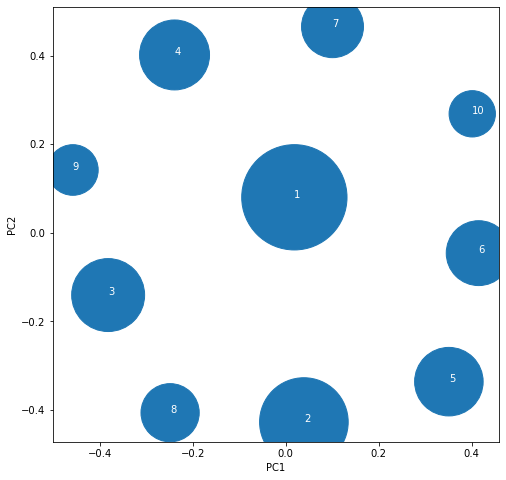

In [197]:
plt.figure(figsize=(8,80))
sc = plt.scatter(vis.topic_coordinates['x'],vis.topic_coordinates['y'],s =(vis.topic_coordinates['Freq']*500).tolist())

plt.xlabel('PC1')
plt.ylabel('PC2')
for i,j,idx in zip(intertopic['PC1'],intertopic['PC2'],intertopic.topics):
    plt.annotate(str(idx),xy=(i,j),color= 'w')

#plt.legend(*sc.legend_elements("sizes", num=6))

#plt.title('Distância intertópica usando PCA')

In [312]:
for num,e in enumerate(corpus):
    for i in range(0,len(lda_model[e])):
        df_f.at[num+1, f'Topico {i + 1}'] = lda_model[e][i][1]

Top 20 frases do topicos 9, sendo ordenada pela contribuição relativa desse tópicos de forma ascendente

In [313]:
topic = 'Topico 9'
inicio = 0
fim = 10
for e,ata,val in zip(df_f.sort_values(topic,ascending=False)['sentenca'][inicio:fim],df_f.sort_values(topic,ascending=False)['ata'][inicio:fim],df_f.sort_values(topic,ascending=False)[topic][inicio:fim]):
    print(ata,'|',e,'>',val)
    print('-------')
    

183ª Reunião - maio 2014 | Para 2015, no cenário de referência, a projeção de inflação recuou em relação ao valor considerado na reunião do Copom de abril, mas se encontra acima da meta > 0.3910807967185974
-------
181ª Reunião - fevereiro 2014 | Para 2015, no cenário de referência, a projeção de inflação reduziu-se em relação ao valor considerado na reunião do Copom de janeiro, mas se encontra acima do valor central da meta > 0.39107242226600647
-------
174ª Reunião - abril 2013 | Para 2014, a projeção de inflação aumentou em relação ao valor considerado na reunião do Copom de março e se encontra acima do valor central da meta, no cenário de referência > 0.37788790464401245
-------
201ª Reunião - agosto 2016 | Ao mesmo tempo, demonstraram preocupação com as expectativas de inflação para 2017 apuradas pela pesquisa Focus e a projeção de inflação para o mesmo ano sob as hipóteses do cenário de mercado, ambas acima da meta de 4,5% > 0.3730306923389435
-------
193ª Reunião - setembro 2015

## Avaliação dos resultados

### Correlação entre os tópicos

In [314]:
corr_df = df_f[df_f.columns[-10:]].corr()

<AxesSubplot:>

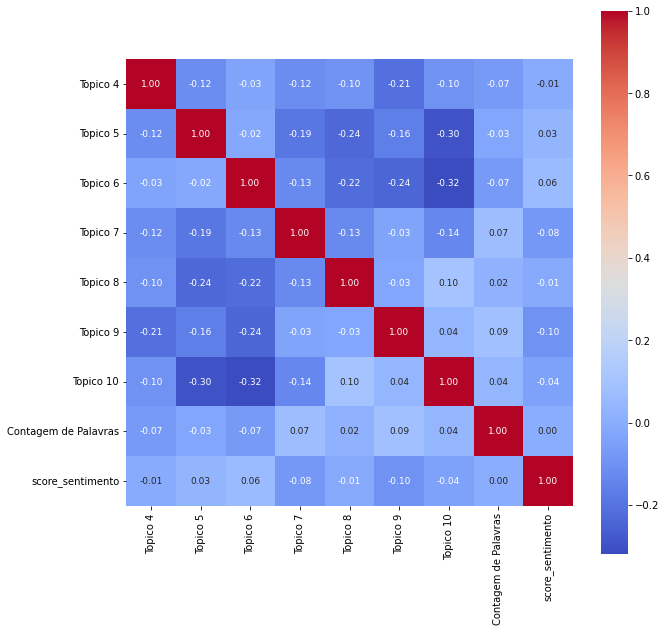

In [315]:
import seaborn as sn
plt.figure(figsize=(10,10))
sn.heatmap(corr_df,annot=True, square=True, fmt='.2f',annot_kws={'size':9},  cmap= "coolwarm")

### Wordcloud

In [320]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(frases,x,y,col):
    wordcloud = WordCloud(width = 600, height = 600,
                          max_words=50,
                    background_color ='white',
                    prefer_horizontal = 1,
                    min_font_size = 10).generate(frases)

    # plot the WordCloud image                      
    #ax[x,y].figure(figsize = (5, 5), facecolor = None)
    ax[x,y].imshow(wordcloud)
    ax[x,y].axis("off")
    ax[x,y].set_title(f'Topico {col}')
    #ax[x,y].tight_layout(pad = 0)
    #ax[x,y].show()
    

### Marcação do principal tópico da frase

In [321]:
topico_cols = df_f.columns[df_f.columns.str.contains('Topico')]
df_f['principal_topico'] = df_f[topico_cols].idxmax(axis=1)

In [322]:
def unir_palavras(x):
    for i in range(0,len(x)):
        x[i] = x[i].replace(' ','_')
    
    return x

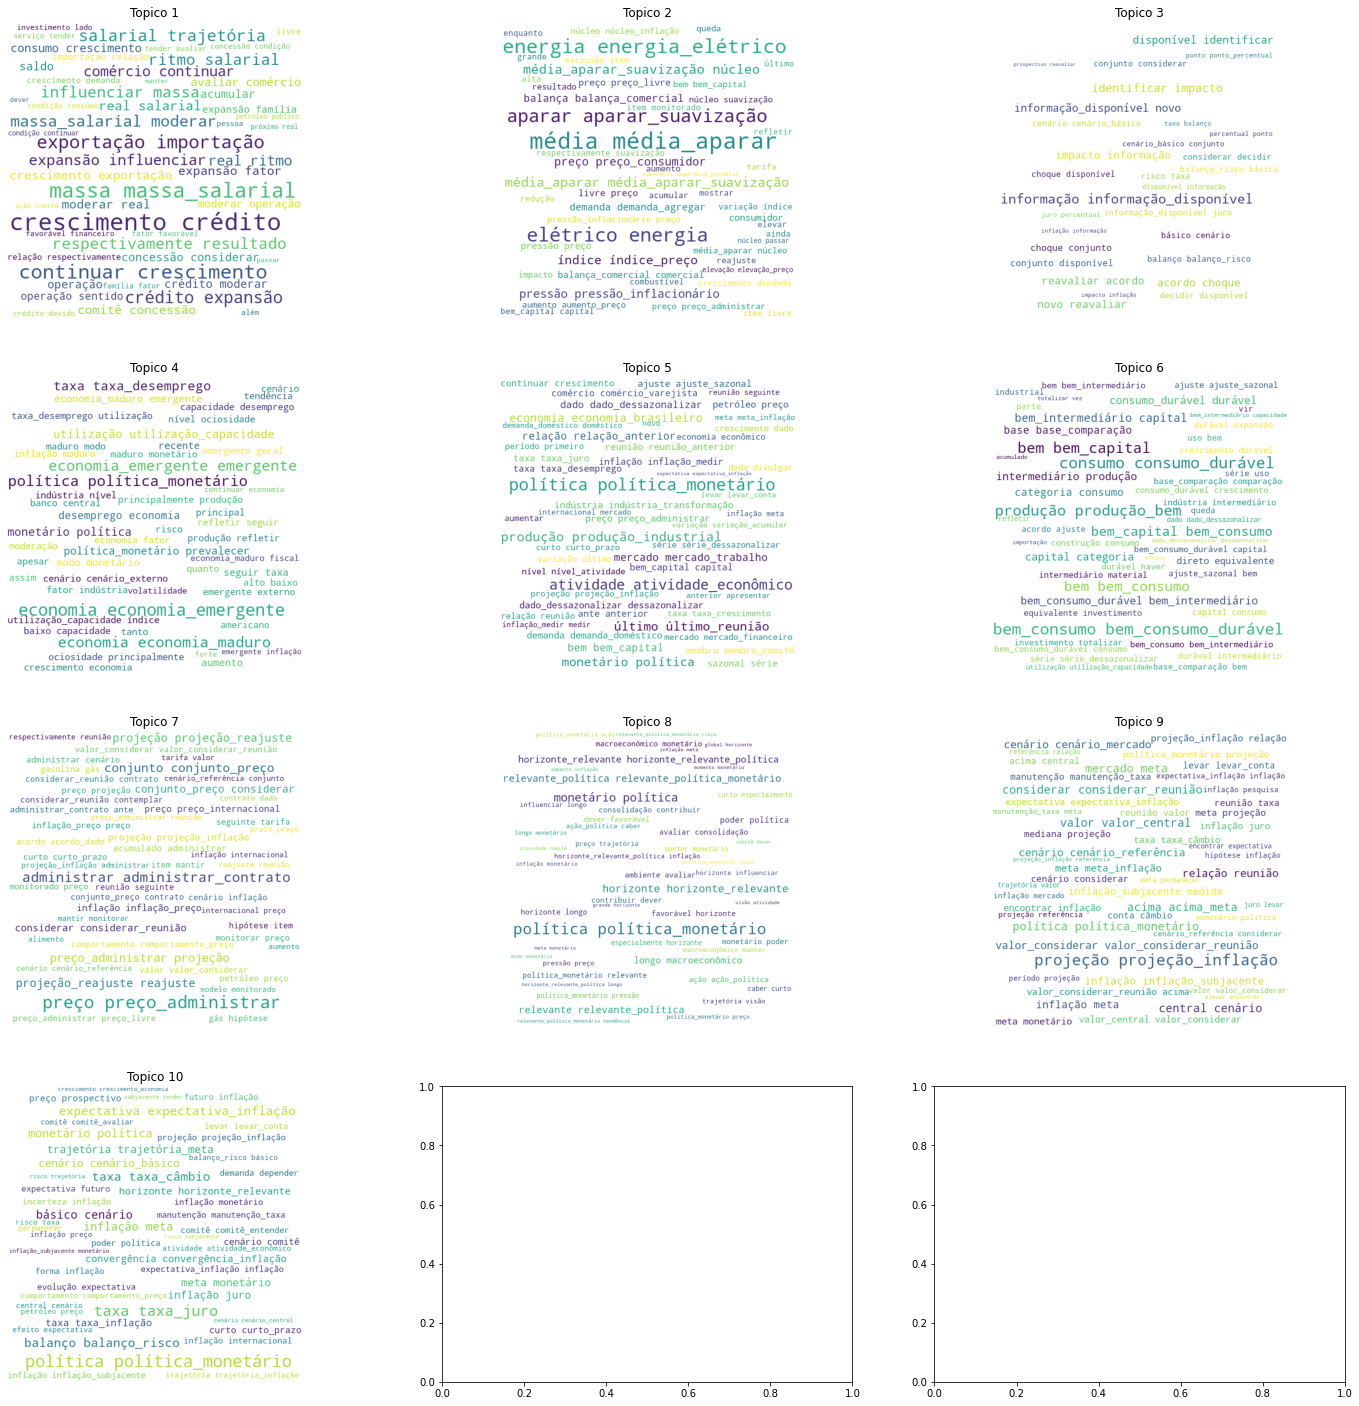

In [323]:
fig,ax = plt.subplots(4,3,figsize=(10*2.5,10*2.5))
col = 1
for x in [0,1,2,3]:
    for y in [0,1,2]:
        frases = ' '.join([' '.join(x) for x in df_f[df_f.principal_topico == f'Topico {col}']['tfidf_preprocess'].apply(lambda x: unir_palavras(x))])
        word_cloud(frases,x,y,col)
        col +=1 
        if col > 10:
            break

# Resultados

Análisando a nuvem de palavras as frases mais importantes para cada tópicos, agrupa-los em macro assuntos e nomea-los os tópicos da seguinte forma.

#### Assunto 1 - Análise de riscos pelo COPOM e no contexto de decisão da politica monetária
- Topico 3: Decisão do COPOM em relação a nova taxa de juros.
- Topico 8: Análises do COPOM para os riscos associados à atividade global, inflação, e sua relevância a política monetária
- Topico 10: Justificativas do COPOM para sua decisão em relação aos juros

#### Assunto 2 - Variáves da atividade economico como Crescimento Economico, Produção industrial, emprego, Exportações e importações
- Topico 1: Análise da demanda doméstica sendo impactada pelas demais variáveis macro-economicas
- **Topico 4**: Riscos externos e riscos associados a ociosidade dos fatores de produção
- Topico 5: Análise das variáveis de Mercado de trabalho, utilização da capacidade industrial, crescimento econômico. Parece que houve uma tendencia em agrupar os que falavam em avanço ou recuperação economica.
- Topico 6: Análise dos indicadores da composição da produção nacional, tais como: Bens de consumo (duráveis e não duráveis), bens intermediários e bens de capital.

#### Assunto 3 - Detalhes de informação de preço, projeções e expectativas de inflação
- Topico 2: Detalhamento dos indicadores do IPCA (IPCA-EX, IPCA-MA,IPCA-MS). Também uma análise dos principais componentes da inflação.
- Topico 7: Análise da projeção de preços das commodities.
- Tópico 9: Projeção da inflação e seu enquadramento na meta

In [324]:
topic_year_df = df_f[['data','Topico 1', 'Topico 2', 'Topico 3', 'Topico 4', 'Topico 5', 'Topico 6',
       'Topico 7', 'Topico 8', 'Topico 9', 'Topico 10']]

In [325]:
topic_year_df= df_f.groupby('data')[['data','Topico 1', 'Topico 2', 'Topico 3', 'Topico 4', 'Topico 5', 'Topico 6',
       'Topico 7', 'Topico 8', 'Topico 9', 'Topico 10']].mean()

In [326]:
topic_year_df.reset_index(inplace=True)

In [327]:
topic_year_df[['Topico 3','Topico 8','Topico 10']].sum(axis=1)

0      0.240017
1      0.259638
2      0.237985
3      0.249605
4      0.226294
         ...   
209    0.323836
210    0.307881
211    0.315975
212    0.303532
213    0.306348
Length: 214, dtype: float64

In [328]:
topic_year_df['Assunto 1'] = topic_year_df[['Topico 3','Topico 8','Topico 10']].sum(axis=1)
topic_year_df['Assunto 2'] = topic_year_df[['Topico 1','Topico 4','Topico 5','Topico 6']].sum(axis=1)
topic_year_df['Assunto 3'] = topic_year_df[['Topico 2','Topico 7','Topico 9']].sum(axis=1)

In [329]:
topic_porc = df_f[['data','principal_topico']].value_counts().reset_index()
topic_porc = topic_porc.rename(columns={0:'contagem'}).sort_values('data',ascending=True)
topic_porc.data = pd.to_datetime(topic_porc.data)

In [330]:
pivot_topic = pd.pivot_table(topic_porc,values='contagem',index='data',columns='principal_topico')
pivot_topic.fillna(0.,inplace=True)

In [331]:
pivot_topic = pivot_topic.apply(lambda x: x/pivot_topic.sum(axis=1))

### Visualização da participação relativa dos tópicos ao longo do tempo

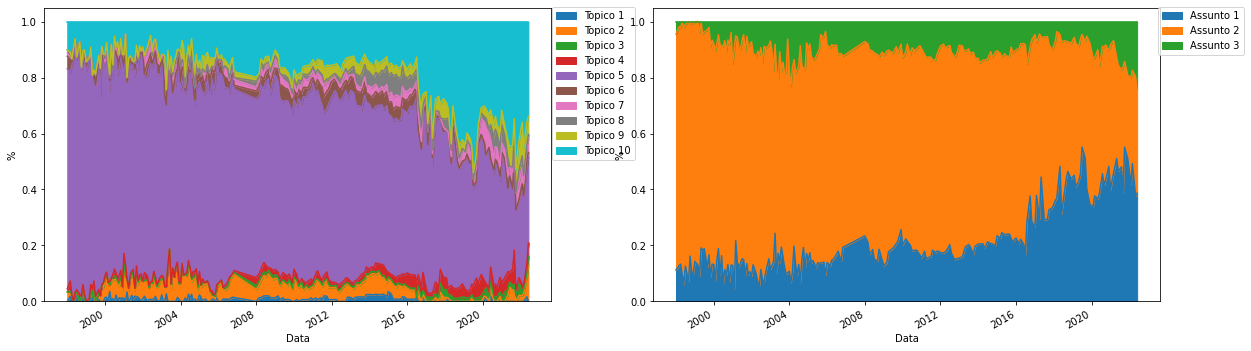

In [332]:

pivot_topic = pivot_topic[['Topico 1','Topico 2','Topico 3','Topico 4','Topico 5','Topico 6','Topico 7','Topico 8','Topico 9','Topico 10']]
fig,ax = plt.subplots(1,2,figsize=(20,6))
pivot_topic.plot(ax=ax[0],kind='area',stacked=True)
ax[0].legend(loc ='center left')
ax[0].set_ylabel('%')
ax[0].set_xlabel('Data')
ax[0].legend(loc="upper right",bbox_to_anchor=(1.175, 1.02))


pivot_topic['Assunto 1'] = pivot_topic[['Topico 3','Topico 8','Topico 10']].sum(axis=1)
pivot_topic['Assunto 2'] = pivot_topic[['Topico 1','Topico 4','Topico 5','Topico 6']].sum(axis=1)
pivot_topic['Assunto 3'] = pivot_topic[['Topico 2','Topico 7','Topico 9']].sum(axis=1)


pivot_topic[['Assunto 1','Assunto 2','Assunto 3']].plot(ax=ax[1],kind='area',stacked=True)
ax[1].legend(loc ='center left')
ax[1].set_ylabel('%')
ax[1].set_xlabel('Data')
ax[1].legend(loc="upper right",bbox_to_anchor=(1.175, 1.02))


In [333]:
pivot_topic['Assunto 1'] = pivot_topic[['Topico 3','Topico 8','Topico 10']].sum(axis=1)
pivot_topic['Assunto 2'] = pivot_topic[['Topico 1','Topico 4','Topico 5','Topico 6']].sum(axis=1)
pivot_topic['Assunto 3'] = pivot_topic[['Topico 2','Topico 7','Topico 9']].sum(axis=1)

In [335]:
topic_porc['porc'] = topic_porc.contagem.apply(lambda x: x/topic_porc.groupby('data')['contagem'].sum()[x])
topic_porc

,data,principal_topico,contagem,porc
1321,1998-01-01,Topico 7,1,0.018182
119,1998-01-01,Topico 5,70,0.714286
885,1998-01-01,Topico 6,4,0.040404
1040,1998-01-01,Topico 2,3,0.041096
1313,1998-01-01,Topico 4,1,0.018182
...,...,...,...,...
296,2022-06-01,Topico 5,19,0.316667
1037,2022-06-01,Topico 4,3,0.041096
831,2022-06-01,Topico 9,4,0.040404
1030,2022-06-01,Topico 7,3,0.041096


#### Análise de sentimento atráves de um dicionário de palavras no jargão economico

In [152]:
import translators as ts

Using Brazil server backend.


#### Importando o dicionário lexico

- Dicionario - https://data.jrc.ec.europa.eu/dataset/1c054ef4-561a-464a-9077-3f6b09630da2
- Paper - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4106936

### Traduzindo o dicionário para lingua portuguesa

In [153]:
econ_dict = pd.read_csv(r"C:\Users\lippe\OneDrive - Unesp\Documentos\Python Scripts\Monografia\Economic-Lexicon.csv")
econ_dict[econ_dict['Unnamed: 3'].isnull()==False]

,token,sentiment,polarity,Unnamed: 3


#### Salvando o dicionario traduzido em arquivo csv

In [154]:
#econ_dict['token_pt'] = econ_dict.token.apply(lambda x:ts.google(x,from_language='en',to_language='pt'))
#welsh = [ts.google(phrase, from_language='en', to_language='pt') for phrase in econ_dict.token]
#fr = 'abandon' ts.baidu(fr,from_language='en',to_language='pt')
#econ_dict.to_csv('Economic-Lexicon-pt.csv',index=False)

In [337]:
econ_dict = pd.read_csv('Economic-Lexicon-pt.csv')
econ_dict

,token,sentiment,polarity,Unnamed: 3,token_pt
0,abandon,-0.50,negative,NaN,abandono
1,abandonment,-0.60,negative,NaN,abandono
2,abdication,-0.25,negative,NaN,abdicação
3,aberration,-0.45,negative,NaN,aberração
4,aberrational,-0.25,negative,NaN,Aberra
...,...,...,...,...,...
4160,yawn,-0.25,negative,NaN,bocejar
4161,young,0.60,positive,NaN,jovem
4162,youth,0.35,positive,NaN,juventude
4163,youthful,0.55,positive,NaN,jovem


### Distribuição da nota de sentimento

(array([1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.147e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-775.        , -721.66666667, -668.33333333, -615.        ,
        -561.66666667, -508.33333333, -455.        , -401.66666667,
        -348.33333333, -295.        , -241.66666667, -188.33333333,
        -135.        ,  -81.66666667,  -28.33333333,   25.        ,
          78.33333333,  131.66666667,  185.        ,  238.33333333,
         291.66666667,  345.        ,  398.33333333,  451.66666667,
         505.        ,  558.33333333,  611.66666667,  665.        ,
         718.33333333,  771.66666667,  825.        ]),
 <BarContainer object of 30 artists>)

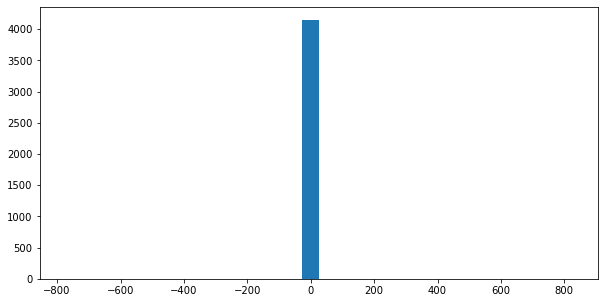

In [338]:
plt.figure(figsize=(10,5))
plt.hist(econ_dict.sentiment,bins=30)

{'whiskers': [<matplotlib.lines.Line2D at 0x2589e0a0970>,
 'caps': [<matplotlib.lines.Line2D at 0x2589e0a0df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2589e0a06a0>],
 'medians': [<matplotlib.lines.Line2D at 0x2589e0af3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2589e0af6a0>],
 'means': []}

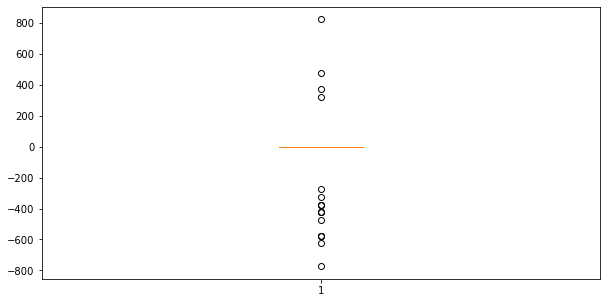

In [339]:
plt.figure(figsize=(10,5))
plt.boxplot(econ_dict.sentiment)

É possível observar que existem valores acima do limite, estes serão considerados como erro de digitação e colocarei dentro do intervalo [-1;1]

In [340]:
econ_dict.sentiment = econ_dict.sentiment.apply(lambda x: x/1000 if (x > 1) | (x < -1) else x )

Text(0.5, 0, 'Nota sentimental')

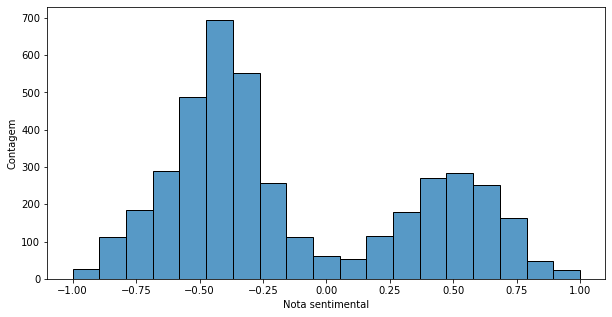

In [341]:
plt.figure(figsize=(10,5))
#plt.hist(econ_dict.sentiment,bins=30,)
sn.histplot(econ_dict.sentiment)
plt.ylabel('Contagem')
plt.xlabel('Nota sentimental')
#plt.title('Distribuição da nota de sentimento do dicionário léxico')

### Aplicando o pre processamento e lemmatização

O mesmo aplicado nas atas

In [342]:
econ_dict['lemmatized_pt'] = lemmatization(econ_dict.token_pt)
econ_dict['lemmatized_pt'] = econ_dict['lemmatized_pt'].apply(lambda x:' '.join(pre_processamento(x)).replace('-',''))

In [343]:
def tratar_duplicados(econ_dict_prov,column):
    econ_dict_prov = econ_dict.copy()
    df_provisorio = pd.DataFrame(columns=econ_dict_prov.columns)
    for i in econ_dict_prov[column].dropna().index:
        x = econ_dict_prov.loc[i,column].split(' ')
        if len(x) > 1:
            while len(x) > 1:
                value = x[-1]
                x.remove(value)
                econ_dict_prov.loc[i,column] = x[-1]  
                linha = econ_dict_prov.iloc[i,:econ_dict_prov.shape[1]]
                linha[column] = value
                df_provisorio.loc[len(df_provisorio),:] = linha
                

    econ_dict_prov = pd.concat([df_provisorio,econ_dict_prov],ignore_index=True)
    return econ_dict_prov


In [344]:
econ_dict = tratar_duplicados(econ_dict,'lemmatized_pt')

### Checando os valores duplicados

Existem valores duplicados por alguns motivos:
Por conta da tradução. Muitas palavras em inglês não possuem sexo em seu significado, e quando traduzido para o português, temos a mesma palavra para amnbos os sexos. Isso foi amenizado com a lemmatização, em tornar todas as palavras para seu lemma. Porém ainda restaram valores nulos de palavras que contém o mesmo lemma. As palavras específicas carregam notas diferentes de sentimento. Para amenizar essa perda, vou agrupar os mesmos lemmas e **tirar a média de seu score de desentimento**

In [345]:
econ_dict[econ_dict.lemmatized_pt.duplicated(keep=False)]

,token,sentiment,polarity,Unnamed: 3,token_pt,lemmatized_pt
0,aborted,-0.45,negative,NaN,abortada abortado,abortar
1,abreast,0.25,positive,NaN,alada alado,alar
3,absurd,-0.45,negative,NaN,absurda absurdo,absurdo
4,abused,-0.9,negative,NaN,abusada abusado,abusar
6,accelerated,0.6,positive,NaN,acelerada acelerado,acelerar
...,...,...,...,...,...,...
5095,wrongfully,-0.45,negative,NaN,injustamente,injustamente
5096,wrongly,-0.55,negative,NaN,incorretamente,incorretamente
5099,young,0.6,positive,NaN,jovem,jovem
5101,youthful,0.55,positive,NaN,jovem,jovem


In [346]:
econ_dict.lemmatized_pt = econ_dict.lemmatized_pt.apply(lambda x:np.nan if x == '' else x)

In [347]:
econ_dict[econ_dict.lemmatized_pt == 'abortar']

,token,sentiment,polarity,Unnamed: 3,token_pt,lemmatized_pt
0,aborted,-0.45,negative,NaN,abortada abortado,abortar
953,abort,-0.5,negative,NaN,abortar,abortar
954,aborted,-0.45,negative,NaN,abortada abortado,abortar


In [348]:
econ_dict.dropna(subset='lemmatized_pt')

,token,sentiment,polarity,Unnamed: 3,token_pt,lemmatized_pt
0,aborted,-0.45,negative,NaN,abortada abortado,abortar
1,abreast,0.25,positive,NaN,alada alado,alar
2,abrupt,-0.3,negative,NaN,abrupta abrupto,abrupto
3,absurd,-0.45,negative,NaN,absurda absurdo,absurdo
4,abused,-0.9,negative,NaN,abusada abusado,abusar
...,...,...,...,...,...,...
5097,yank,-0.15,negative,NaN,puxão,puxao
5098,yawn,-0.25,negative,NaN,bocejar,bocejar
5099,young,0.6,positive,NaN,jovem,jovem
5100,youth,0.35,positive,NaN,juventude,juventude


In [349]:
econ_lex = econ_dict.dropna(subset='lemmatized_pt').groupby('lemmatized_pt')['sentiment'].mean()
econ_lex.describe()

count    3395.000000
mean       -0.109418
std         0.473394
min        -1.000000
25%        -0.466667
50%        -0.300000
75%         0.400000
max         1.000000
Name: sentiment, dtype: float64

### Palavras adicionadas de maneira exógena

In [350]:
econ_lex['crescimento'] = econ_lex['crescer']
econ_lex['normalizacao'] = econ_lex['normalizar']

In [357]:
def score_frase(frase):
    # Calculo do score de uma frase
    score = 0
    n_palavras = 0
    
    for w in frase:
        if w in econ_lex.index:
            n_palavras += 1
            score += econ_lex[w]
            
        else:
            list_words.append(w)
    if n_palavras == 0:
        sentiment = 0.0
    else:
        sentiment = score/n_palavras
    
    return sentiment
        
        


In [352]:
list_words = []
df_f['score_sentimento'] = df_f['lemma_preprocess'].apply(lambda x:score_frase(x))


### Aplicando o processo através da técnica Stemming

In [353]:
econ_dict['stemmed_pt'] = econ_dict.dropna(subset=['lemmatized_pt']).lemmatized_pt.apply(lambda x:stemming(x))
econ_dict['stemmed_pt'] = econ_dict.dropna(subset=['lemmatized_pt'])['stemmed_pt'].apply(lambda x:' '.join(pre_processamento(x)).replace('-',''))

In [354]:
econ_lex = econ_dict.dropna(subset='stemmed_pt').groupby('stemmed_pt')['sentiment'].mean()
econ_lex.describe()

count    2779.000000
mean       -0.108660
std         0.464007
min        -1.000000
25%        -0.450000
50%        -0.300000
75%         0.391667
max         1.000000
Name: sentiment, dtype: float64

In [355]:
list_words = []
df_f['score_sentimento'] = df_f['stem_preprocess'].apply(lambda x:score_frase(x))


In [356]:
econ_lex[stemming('negativo')]

-0.55

In [261]:
stemming('negativo')

'nega'

In [262]:
df_f.loc[df_f.score_sentimento.idxmin(),'sentenca']

'Logo em seguida, tem-se a Agropecuária e os Serviços, que demitiram 134.487 e 117.128 pessoas, respectivamente'

In [263]:

df_f[['Topico 1', 'Topico 2', 'Topico 3', 'Topico 4', 'Topico 5', 'Topico 6',
       'Topico 7', 'Topico 8', 'Topico 9', 'Topico 10','principal_topico']]

,Topico 1,Topico 2,Topico 3,Topico 4,Topico 5,Topico 6,Topico 7,Topico 8,Topico 9,Topico 10,principal_topico
1,0.071994,0.092913,0.036647,0.082542,0.244886,0.090640,0.072255,0.034703,0.121439,0.151974,Topico 5
2,0.122679,0.173239,0.097403,0.130226,0.139729,0.064831,0.051681,0.060417,0.033334,0.126460,Topico 2
3,0.097492,0.154106,0.029346,0.066098,0.196286,0.072582,0.137539,0.027789,0.037319,0.181443,Topico 5
4,0.115978,0.135916,0.034910,0.078629,0.186094,0.133751,0.068829,0.080465,0.044394,0.121034,Topico 5
5,0.081299,0.228201,0.024473,0.055121,0.163587,0.093762,0.081484,0.080495,0.031121,0.160454,Topico 2
...,...,...,...,...,...,...,...,...,...,...,...
23004,0.053393,0.068907,0.027179,0.061216,0.181790,0.104130,0.053586,0.247191,0.071471,0.131137,Topico 8
23005,0.072784,0.128768,0.061158,0.092621,0.162461,0.078917,0.056500,0.109626,0.052141,0.185024,Topico 10
23006,0.051493,0.066455,0.026212,0.130226,0.175317,0.100425,0.122867,0.024821,0.140118,0.162065,Topico 5
23007,0.096467,0.083892,0.037671,0.209544,0.215330,0.104598,0.053191,0.058518,0.020316,0.120474,Topico 5


In [264]:
df_f.principal_topico.value_counts()

Topico 5     14991
Topico 10     3847
Topico 2      1085
Topico 6       705
Topico 9       617
Topico 7       566
Topico 4       437
Topico 8       370
Topico 1       202
Topico 3       188
Name: principal_topico, dtype: int64

In [265]:
df_f.groupby('principal_topico')['score_sentimento'].mean()

principal_topico
Topico 1     0.153134
Topico 10    0.047830
Topico 2     0.074935
Topico 3     0.070790
Topico 4    -0.002587
Topico 5     0.071022
Topico 6     0.161779
Topico 7    -0.021160
Topico 8     0.055732
Topico 9    -0.003910
Name: score_sentimento, dtype: float64

# Assunto 3 - Detalhes de informação de preço, projeções e expectativas de inflação

<AxesSubplot:xlabel='data', ylabel='score_sentimento'>

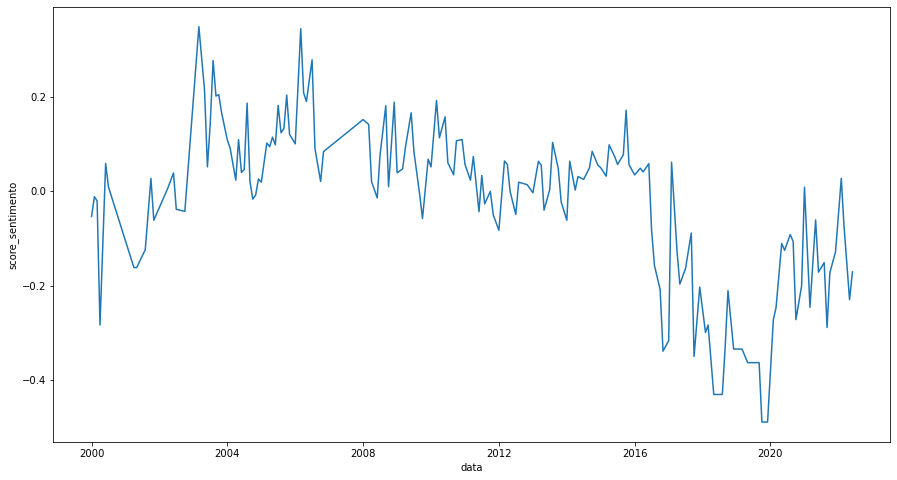

In [358]:
plt.figure(figsize=(15,8))
topic_9 = ['Topico 9']
topic_9 = df_f[df_f.principal_topico.isin(topic_9)]
topic_9 = topic_9.groupby('data')['score_sentimento'].mean().reset_index().sort_values('data')
topic_9['Variação % IndSent'] = topic_9.score_sentimento.diff(1)
topic_9['Média móvel'] = topic_9['Variação % IndSent'].rolling(12).mean()

sn.lineplot(data=topic_9.sort_values('data'),x= 'data',y='score_sentimento')

#### Serie temporal da média movel da diferença com a anterior

<AxesSubplot:xlabel='data', ylabel='Média móvel'>

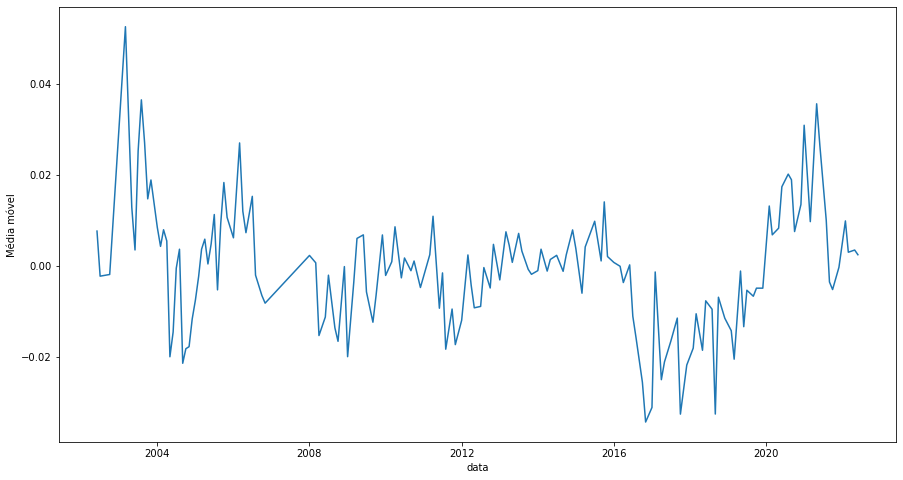

In [297]:
plt.figure(figsize=(15,8))
sn.lineplot(data=topic_9.sort_values('data'),x= 'data',y='Média móvel')

<AxesSubplot:xlabel='data', ylabel='score_sentimento'>

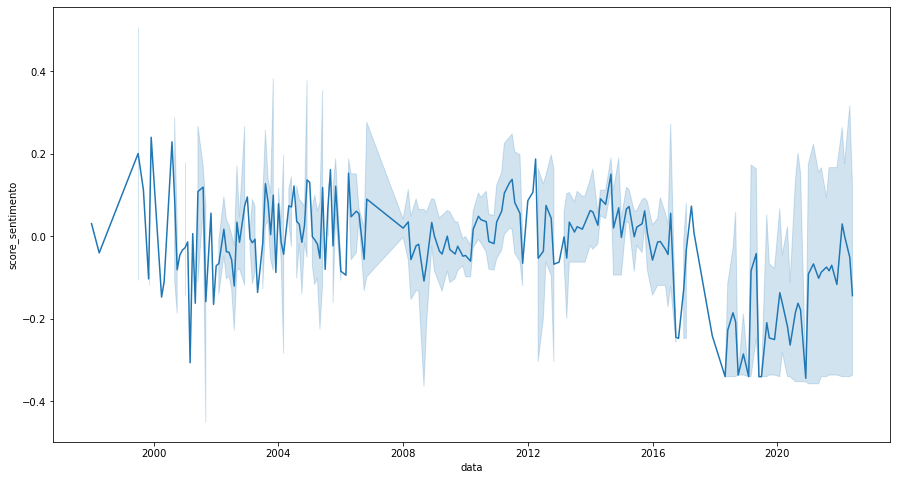

In [268]:
plt.figure(figsize=(15,8))
topicos_7 = ['Topico 7']
topicos_7 = df_f[df_f.principal_topico.isin(topicos_7)]
sn.lineplot(data=topicos_7.sort_values('data'),x= 'data',y='score_sentimento')

<AxesSubplot:xlabel='data', ylabel='score_sentimento'>

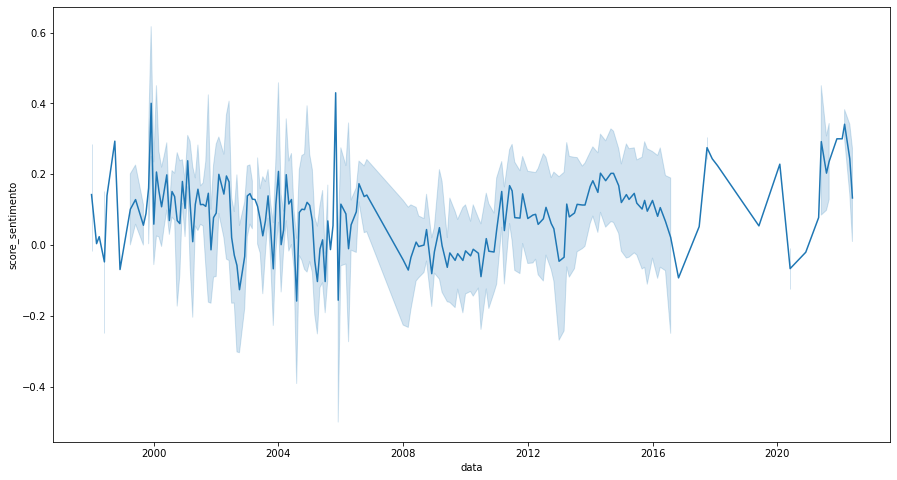

In [269]:
plt.figure(figsize=(15,8))
topicos_2 = ['Topico 2']
topicos_2 = df_f[df_f.principal_topico.isin(topicos_2)]
sn.lineplot(data=topicos_2.sort_values('data'),x= 'data',y='score_sentimento')

<AxesSubplot:xlabel='data', ylabel='score_sentimento'>

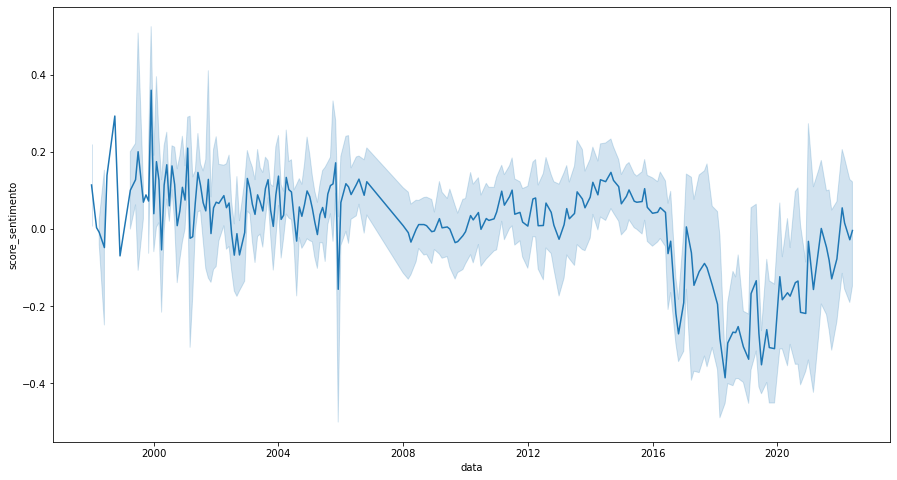

In [270]:
plt.figure(figsize=(15,8))
topicos_inf = ['Topico 9','Topico 2','Topico 7']
topic_inf = df_f[df_f.principal_topico.isin(topicos_inf)]
sn.lineplot(data=topic_inf.sort_values('data'),x= 'data',y='score_sentimento')

Assunto 3 - Detalhes de informação de preço, projeções e expectativas de inflação
- Topico 2: Detalhamento dos indicadores do IPCA (IPCA-EX, IPCA-MA,IPCA-MS). Também uma análise dos principais componentes da inflação.
- Topico 7: Análise da projeção de preços das commodities.
- Tópico 9: Projeção da inflação e seu enquadramento na meta

<AxesSubplot:xlabel='data', ylabel='score_sentimento'>

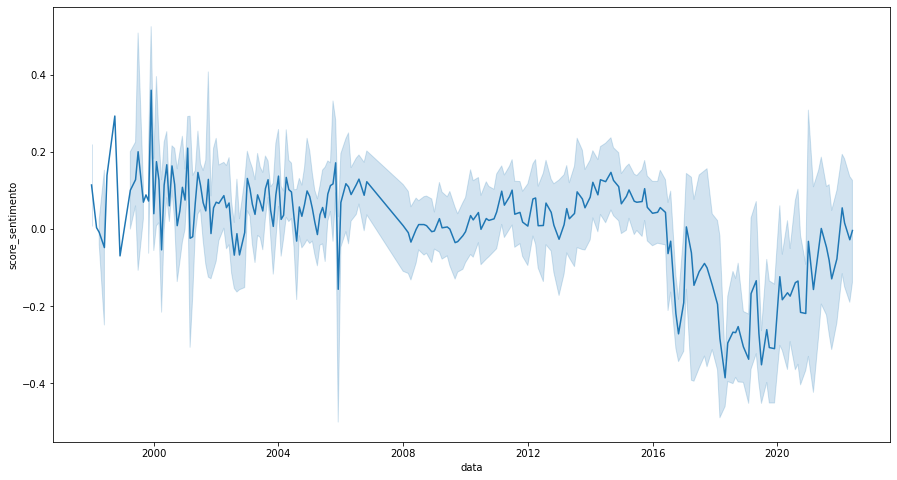

In [272]:
plt.figure(figsize=(15,8))
topicos_inf = ['Topico 9','Topico 2','Topico 7']
topic_inf = df_f[df_f.principal_topico.isin(topicos_inf)]
sn.lineplot(data=topic_inf.sort_values('data'),x= 'data',y='score_sentimento')

### Contra IPCA


https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=resultados

In [273]:
ipca= pd.read_csv(r"C:\Users\lippe\OneDrive - Unesp\Documentos\Python Scripts\Monografia\ipca_serie.csv",sep=';')
focus = pd.read_json(r"C:\Users\lippe\OneDrive - Unesp\Documentos\Python Scripts\Monografia\expectativa_inf.json")

In [274]:
ipca = ipca.dropna(subset=' 12 MESES')
ipca = ipca.reset_index(drop=True)

In [275]:
meses_dict = {
    'janeiro':'01',
    'fevereiro':'02',
    'março':'03',
    'abril':'04',
    'maio':'05',
    'junho':'06',
    'julho':'07',
    'agosto':'08',
    'setembro':'09',
    'outubro':'10',
    'novembro':'11',
    'dezembro':'12'
}

In [276]:
new_dict = {}
for k,v in meses_dict.items():
    new_dict[k[:3]] = v

In [277]:
ipca['mes'] = ipca['Unnamed: 1'].apply(lambda x: new_dict[x.lower()])

In [278]:
for num,(ano,mes) in enumerate(zip(ipca['Unnamed: 0'],ipca['mes'])):
    data = f'{mes}/{int(ano)}'
    ipca.loc[num,'data'] = datetime.strptime(data, '%m/%Y')

In [279]:
ipca[' 12 MESES'] = ipca[' 12 MESES'].apply(lambda x :x.replace('.','').replace(',','.'))
ipca[' 12 MESES'] = ipca[' 12 MESES'].astype('float64')

In [280]:
ipca.rename(columns={' 12 MESES':'IPCA'},inplace=True)

In [281]:
ipca

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Mes,MESES,MESES.1,ANO,IPCA,mes,data
0,1994.0,JAN,"141,31","41,31","162,13","533,33","41,31",2693.84,01,1994-01-01
1,1994.0,FEV,"198,22","40,27","171,24","568,17","98,22",3035.71,02,1994-02-01
2,1994.0,MAR,"282,96","42,75","182,96","602,93","182,96",3417.39,03,1994-03-01
3,1994.0,ABR,"403,73","42,68","185,71","648,92","303,73",3828.49,04,1994-04-01
4,1994.0,MAI,"581,49","44,03","193,36","695,71","481,49",4331.19,05,1994-05-01
...,...,...,...,...,...,...,...,...,...,...
337,2022.0,FEV,"6215,24","1,01","2,3","5,77","1,56",10.54,02,2022-02-01
338,2022.0,MAR,"6315,93","1,62","3,2","6,25","3,2",11.30,03,2022-03-01
339,2022.0,ABR,"6382,88","1,06","3,73","6,05","4,29",12.13,04,2022-04-01
340,2022.0,MAI,"6412,88","0,47","3,18","5,55","4,78",11.73,05,2022-05-01


def tratar_focus(df_focus,x):
    data = x['Data']
    media = x['Media']
    row = len(df_focus)
    df_focus.loc[row,'Data'] = data
    df_focus.loc[row,'Media'] = media
    #print(data,media)
    
    
df_focus = pd.DataFrame(columns=['Data','Media'])   

focus.value.apply(lambda x:tratar_focus(df_focus,x))

df_focus['anomes'] = df_focus.Data.apply(lambda x:f'{x.year}0{x.month}' if x.month < 10 else f'{x.year}{x.month}') 
df_focus_tratada = df_focus.groupby('anomes')['Media'].mean()
df_focus_tratada = df_focus_tratada.reset_index()
df_focus_tratada.to_csv('df_focus_tratada.csv',index=False)

df_focus_tratada = pd.read_csv('df_focus_tratada.csv')

In [286]:
df_focus_tratada = pd.read_csv('df_focus_tratada.csv')

In [287]:
df_focus_tratada['date'] = pd.to_datetime(df_focus_tratada.anomes,format='%Y%m')

In [288]:
df_focus_tratada.rename(columns={'Media':'Expectativa Inflação'},inplace=True)

In [289]:
df_focus_tratada['variação'] = df_focus_tratada['Expectativa Inflação'].pct_change(periods=1)

In [290]:
df_focus_tratada['Media Móvel Expectativa Inflação'] = df_focus_tratada['Expectativa Inflação'].rolling(6).mean()

In [291]:
df_focus_tratada

,anomes,Expectativa Inflação,date,variação,Media Móvel Expectativa Inflação
0,200111,6.720446,2001-11-01,NaN,NaN
1,200112,6.329212,2001-12-01,-0.058215,NaN
2,200201,5.621307,2002-01-01,-0.111847,NaN
3,200202,5.629967,2002-02-01,0.001541,NaN
4,200203,5.692313,2002-03-01,0.011074,NaN
...,...,...,...,...,...
244,202203,5.961730,2022-03-01,0.102616,5.429973
245,202204,5.946272,2022-04-01,-0.002593,5.580189
246,202205,6.134355,2022-05-01,0.031630,5.675512
247,202206,5.970109,2022-06-01,-0.026775,5.782536


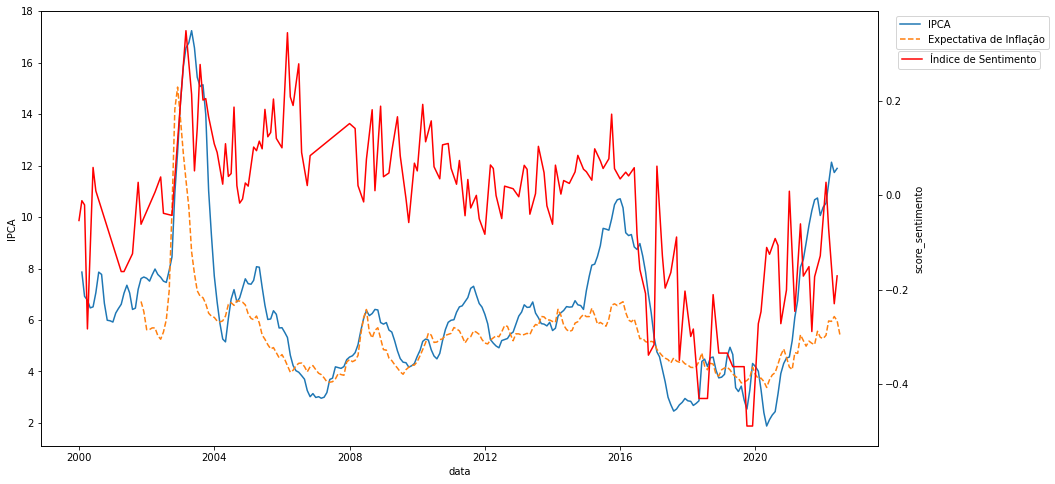

In [292]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sn.lineplot(data= ipca[ipca.data > '2000-01-01'],x= 'data', y='IPCA',label= 'IPCA')
sn.lineplot(data= df_focus_tratada,x= 'date',y='Expectativa Inflação',linestyle='--',label= 'Expectativa de Inflação')
plt.legend(loc="upper right",bbox_to_anchor=(1.21, 1))
ax2 = plt.twinx()
sn.lineplot(data=topic_9.sort_values('data'),x= 'data',y='score_sentimento',color='r',ax=ax2,label= 'Índice de Sentimento')


ax2.legend(loc="upper right",bbox_to_anchor=(1.2, 0.92))

In [293]:
ipca['Variação % IPCA'] = ipca.IPCA.pct_change(1)
ipca['Media Móvel'] = ipca['Variação % IPCA'].rolling(6).mean()

In [294]:
topic_9

,data,score_sentimento,Variação % IndSent,Média móvel
0,2000-01-01,-0.053846,NaN,NaN
1,2000-02-01,-0.011905,0.041941,NaN
2,2000-03-01,-0.020833,-0.008929,NaN
3,2000-04-01,-0.283333,-0.262500,NaN
4,2000-06-01,0.058422,0.341755,NaN
...,...,...,...,...
165,2021-12-01,-0.128603,0.044274,-0.000273
166,2022-02-01,0.027037,0.155640,0.009918
167,2022-03-01,-0.070420,-0.097457,0.003036
168,2022-05-01,-0.229998,-0.159578,0.003519


In [299]:
a=pd.DataFrame()

In [306]:
for c in range(1,4):
    for i in range(1,4):
        a.loc[c,i] = (fr'\varphi_{c,i}')
        print(fr'\varphi_{c,i}')

\varphi_(1, 1)
\varphi_(1, 2)
\varphi_(1, 3)
\varphi_(2, 1)
\varphi_(2, 2)
\varphi_(2, 3)
\varphi_(3, 1)
\varphi_(3, 2)
\varphi_(3, 3)


In [307]:
a

,1,2,3
1,"\varphi_(1, 1)","\varphi_(1, 2)","\varphi_(1, 3)"
2,"\varphi_(2, 1)","\varphi_(2, 2)","\varphi_(2, 3)"
3,"\varphi_(3, 1)","\varphi_(3, 2)","\varphi_(3, 3)"


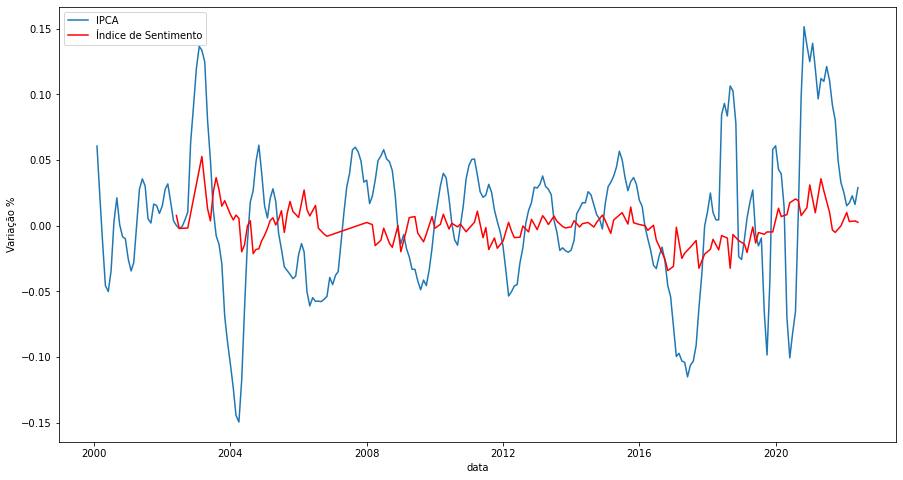

In [298]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sn.lineplot(data= ipca[ipca.data > '2000-01-01'],x= 'data', y='Media Móvel',label= 'IPCA')
#sn.lineplot(data= df_focus_tratada,x= 'date',y='Expectativa Inflação',linestyle='--',label= 'Expectativa de Inflação')
plt.legend(loc="upper right",bbox_to_anchor=(1.21, 1))
# ax2 = plt.twinx()
sn.lineplot(data=topic_9.sort_values('data'),x= 'data',y='Média móvel',color='r',
            
            label= 'Índice de Sentimento')
plt.ylabel('Variação %')

ax2.legend(loc="upper right",bbox_to_anchor=(1.2, 0.92))

In [429]:
ipca_filtrado = ipca[ipca['data'].isin(topic_9.dropna(subset='Média móvel').data)]
ipca_filtrado

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Mes,MESES,MESES.1,ANO,IPCA,mes,data,Variação % IPCA,Media Móvel
101,2002.0,JUN,"1866,02","0,42","1,44","2,94","2,94",7.66,06,2002-06-01,-0.014157,0.000035
102,2002.0,JUL,"1888,23","1,19","1,83","3,63","4,17",7.51,07,2002-07-01,-0.019582,-0.002143
105,2002.0,OUT,"1939,26","1,31","2,7","4,58","6,98",8.45,10,2002-10-01,0.065574,0.010311
110,2003.0,MAR,"2144,49","1,23","5,13","12,03","5,13",16.57,03,2003-03-01,0.045426,0.133512
112,2003.0,MAI,"2178,5","0,61","2,84","9,04","6,8",17.24,05,2003-05-01,0.028026,0.080351
...,...,...,...,...,...,...,...,...,...,...,...,...
335,2021.0,DEZ,"6120,04","0,73","2,96","6,07","10,06",10.06,12,2021-12-01,-0.063315,0.032751
337,2022.0,FEV,"6215,24","1,01","2,3","5,77","1,56",10.54,02,2022-02-01,0.015414,0.015055
338,2022.0,MAR,"6315,93","1,62","3,2","6,25","3,2",11.30,03,2022-03-01,0.072106,0.017259
340,2022.0,MAI,"6412,88","0,47","3,18","5,55","4,78",11.73,05,2022-05-01,-0.032976,0.016082


In [439]:
np.corrcoef(topic_9.dropna(subset='Média móvel')['score_sentimento'],ipca_filtrado['IPCA'])

array([[1.        , 0.37577856],
       [0.37577856, 1.        ]])

In [435]:
np.corrcoef(topic_9.dropna(subset='Média móvel')['Média móvel'],ipca_filtrado['Media Móvel'])


array([[1.        , 0.20434719],
       [0.20434719, 1.        ]])

### Atividade economica



In [191]:
ibcbr = pd.read_json(r"C:\Users\lippe\OneDrive - Unesp\Documentos\Python Scripts\Monografia\IBC-br.json.txt")
ibcbr['data'] = pd.to_datetime(ibcbr['data'],format= '%d/%m/%Y')

In [192]:
ibcbr['variação'] = ibcbr.valor.pct_change(periods=12)

In [193]:
ibcbr = ibcbr.rename(columns={'valor':'IBR-Br'})

In [194]:
topic_5 = df_f[(df_f.principal_topico.isin(['Topico 5','Topico 1','Topico 4','Topico 6'])) & (df_f.data > '2003')]

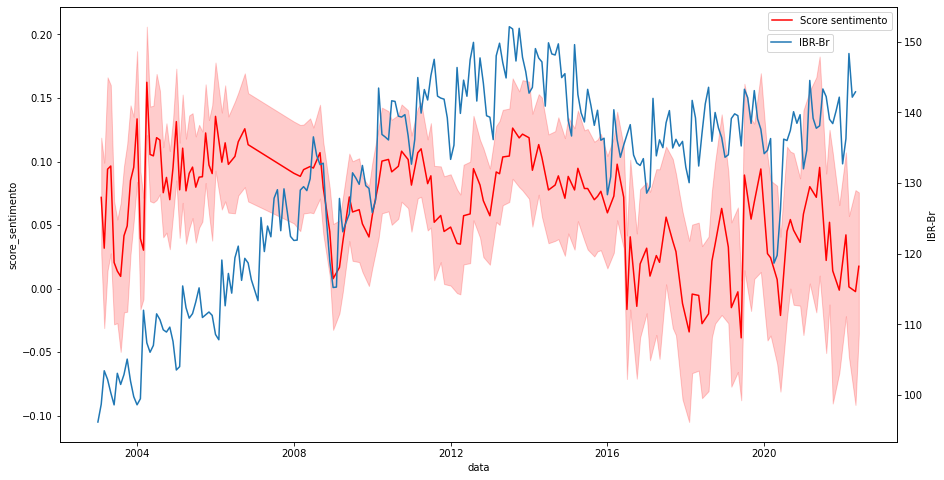

In [195]:
plt.figure(figsize=(15,8))


sn.lineplot(data=topic_5.sort_values('data'),x= 'data',y='score_sentimento',color='r',label= 'Score sentimento')
plt.legend(loc="upper right",bbox_to_anchor=(1, 1))
#sn.lineplot(data= ibcbr,x= 'data',y='variação',linestyle='--',color='b',label= 'Variação do IBC-Br')
ax2 = plt.twinx()
sn.lineplot(data= ibcbr,x= 'data',y='IBR-Br',ax=ax2,label= 'IBR-Br')
plt.legend()
ax2.legend(loc="upper right",bbox_to_anchor=(0.93, 0.95))

<AxesSubplot:xlabel='data', ylabel='score_sentimento'>

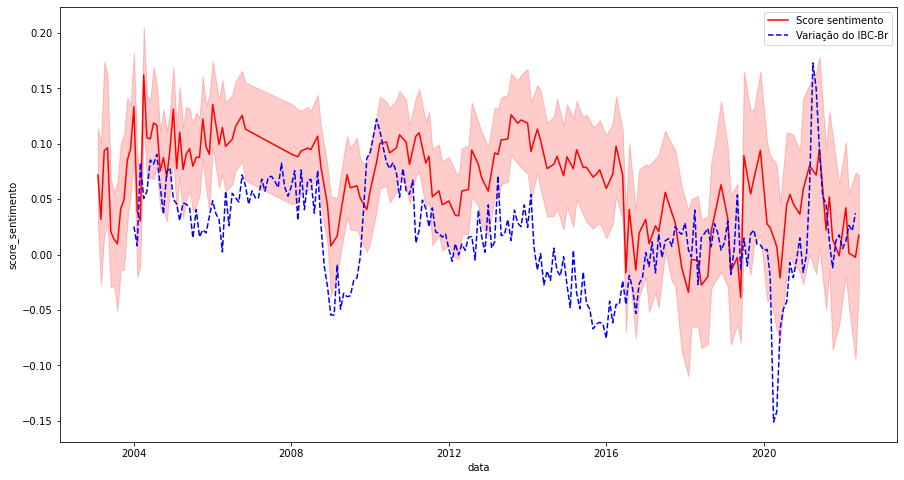

In [196]:
plt.figure(figsize=(15,8))
sn.lineplot(data=topic_5.sort_values('data'),x= 'data',y='score_sentimento',color='r',label= 'Score sentimento')
sn.lineplot(data= ibcbr,x= 'data',y='variação',linestyle='--',color='b',label= 'Variação do IBC-Br')

In [1797]:
plt.figure(figsize=(15,8))
px.line(ibcbr,x= 'data',y='variação',)
#sn.lineplot(data= ibcbr,x= 'data',y='variação',linestyle='--',color='b',label= 'Variação do IBC-Br')

C:\Users\lippe\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\lippe\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



<Figure size 1080x576 with 0 Axes>

In [1229]:
ibcbr[ibcbr.data == '2016']

,data,valor
156,2016-01-01,128.34


In [1244]:
df_f.loc[5,'sentenca']

'Na visão do Comitê, esses desenvolvimentos podem ter consequências de longo prazo e se traduzir em pressões inflacionárias mais prolongadas na produção global de bens.\n2'

In [1245]:
df_f.loc[5,'lemma_preprocess_grams']

'visao comite desenvolvimento poder ter consequencia longo prazo traduzir pressao_inflacionario prolongar producao global bem'

In [1241]:
df_f.loc[5,'stem_preprocess']

['vis',
 'comite',
 'ess',
 'desenvolv',
 'pod',
 'ter',
 'consequ',
 'long',
 'praz',
 'traduz',
 'press',
 'inflacionar',
 'prolong',
 'produc',
 'glob',
 'bens.',
 '2']

In [1248]:
df_f.data.min()

Timestamp('1998-01-01 00:00:00')